In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch

In [2]:
import torch
import matplotlib.pyplot as plt

def plot_sigmoid_inventory_control(breakpoints, temperature, plot_type='both', figsize=(12, 6)):
    if not isinstance(breakpoints, torch.Tensor):
        breakpoints = torch.tensor(breakpoints, dtype=torch.float32)
    
    x_min = breakpoints[0] - max(1.0, temperature * 3)
    x_max = breakpoints[-1] + max(1.0, temperature * 3)
    x = torch.linspace(x_min, x_max, 10000)
    
    if plot_type == 'both':
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    else:
        fig, ax = plt.subplots(figsize=figsize)
    
    n_ranges = len(breakpoints) - 1
    weights = torch.zeros((len(x), n_ranges))
    
    # Compute range lengths
    range_lengths = breakpoints[1:] - breakpoints[:-1]
    max_range_length = torch.max(range_lengths)
    
    # Create scaling factors for each breakpoint
    breakpoint_scalings = torch.ones(len(breakpoints))
    
    # For internal breakpoints, use scaling from the next range
    for i in range(1, len(breakpoints) - 1):
        next_range_length = range_lengths[i]
        breakpoint_scalings[i] = max_range_length / next_range_length
    
    # For first and last breakpoints, use scaling from adjacent range
    breakpoint_scalings[0] = max_range_length / range_lengths[0]
    breakpoint_scalings[-1] = max_range_length / range_lengths[-1]
    
    for i in range(n_ranges):
        a_k = breakpoints[i]
        a_k_plus_1 = breakpoints[i+1]
        
        # Get scaling factors for left and right breakpoints of this range
        left_scaling = breakpoint_scalings[i]
        right_scaling = breakpoint_scalings[i+1]
        
        # Calculate sigmoid values
        if i == 0:
            # For leftmost range, left sigmoid is always 1
            left_sigmoid = torch.ones_like(x)
            right_sigmoid = torch.sigmoid((right_scaling * (x - a_k_plus_1)) / temperature)
        elif i == n_ranges - 1:
            # For rightmost range, right sigmoid is always 0
            left_sigmoid = torch.sigmoid((left_scaling * (x - a_k)) / temperature)
            right_sigmoid = torch.zeros_like(x)
        else:
            # Normal case for middle ranges
            left_sigmoid = torch.sigmoid((left_scaling * (x - a_k)) / temperature)
            right_sigmoid = torch.sigmoid((right_scaling * (x - a_k_plus_1)) / temperature)
            
        sigmoid_diff = left_sigmoid - right_sigmoid
        weights[:, i] = torch.clamp(sigmoid_diff, 0.0, 1.0)
    
    total_weights = weights.sum(dim=1, keepdim=True)
    probs = weights / (total_weights + 1e-10)
    
    # Visualization remains the same
    if plot_type in ['weights', 'both']:
        ax_weights = ax1 if plot_type == 'both' else ax
        for i in range(n_ranges):
            range_name = f"Range {i} [{breakpoints[i]:.4f}, {breakpoints[i+1]:.4f}]"
            ax_weights.plot(x.numpy(), weights[:, i].numpy(), label=range_name)
        for bp in breakpoints:
            ax_weights.axvline(x=bp.item(), color='gray', linestyle='--', alpha=0.5)
        ax_weights.set_title(f'Scaled Sigmoid Differences (τ = {temperature:.1f})')
        ax_weights.set_xlabel('Order Quantity')
        ax_weights.set_ylabel('Weight')
        ax_weights.set_ylim(0, 1.1)
        ax_weights.legend()
        ax_weights.grid(True, alpha=0.3)
    
    if plot_type in ['probs', 'both']:
        ax_probs = ax2 if plot_type == 'both' else ax
        for i in range(n_ranges):
            range_name = f"P(Range {i})"
            if i == 0:
                range_name = "P(No Order)"
            elif i == 1:
                range_name = "P(Order)"
            ax_probs.plot(x.numpy(), probs[:, i].numpy(), label=range_name)
        for bp in breakpoints:
            ax_probs.axvline(x=bp.item(), color='gray', linestyle='--', alpha=0.5)
        ax_probs.set_title(f'Implied Probabilities (τ = {temperature:.1f})')
        ax_probs.set_xlabel('Order Quantity')
        ax_probs.set_ylabel('Probability')
        ax_probs.set_ylim(0, 1.1)
        ax_probs.legend()
        ax_probs.grid(True, alpha=0.3)
    
    plt.tight_layout()
    return fig, ax1 if plot_type == 'both' else ax

(<Figure size 1200x600 with 1 Axes>,
 <Axes: title={'center': 'Implied Probabilities (τ = 1.9)'}, xlabel='Order Quantity', ylabel='Probability'>)

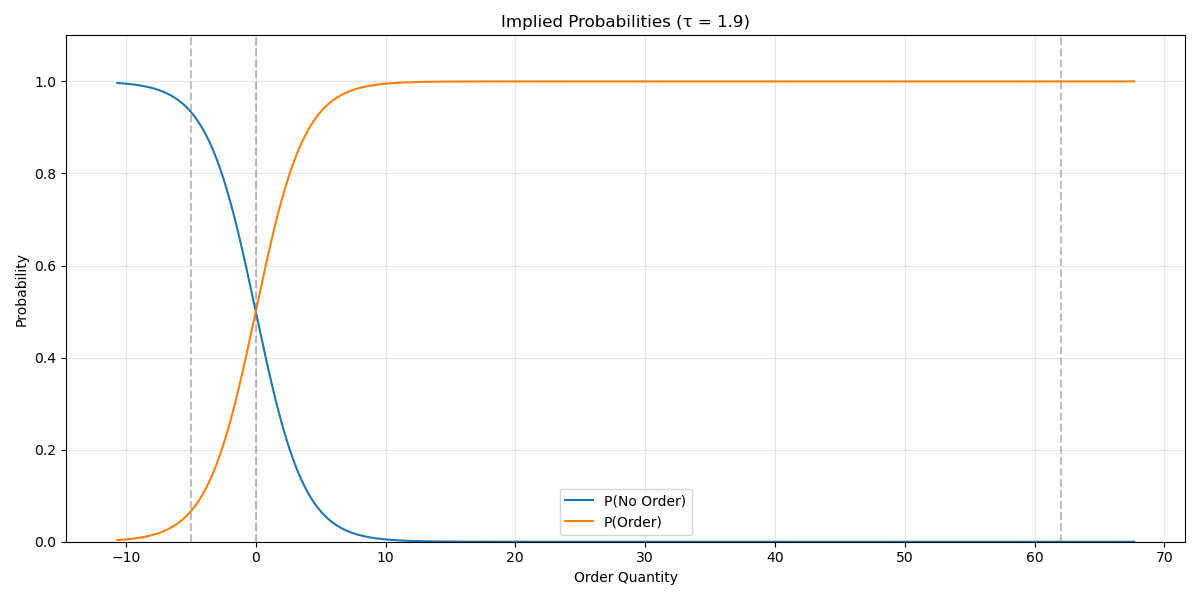

In [6]:
# %matplotlib notebook
%matplotlib ipympl

# Plot only probabilities with temperature = 0.5
plot_sigmoid_inventory_control(
    # breakpoints=[0.0, 18.4, 62],
    breakpoints=[-5.0, 0.0, 62],
    temperature=1.89,
    # temperature=0.1,
    plot_type='probs'
)

# # Plot only weights with temperature = 0.1
# plot_sigmoid_inventory_control(
#     breakpoints=[-0.0001, 0, 62],
#     temperature=0.1,
#     plot_type='weights'
# )

# # Plot both with temperature = 2.0
# plot_sigmoid_inventory_control(
#     breakpoints=[-0.0001, 0, 62],
#     temperature=2.0,
#     plot_type='both'
# )